# Research In Computing - Demand Forecasting

## Applying SARIMA Model

Task: The dataset (Historical Product Demand.csv) contains the 6 years of order demand observations from many locations for multiple products. The goal is to develop a model to predict the demand for particular product.

We will be following this example step-by-step in this assessment:
1. Importing the libraries
1. Loading the data
1. Cleaning the data
1. Analyzing the dataset
1. Data Visualization
1. Seasonal Decomposition of the data
1. Applying loop for SARIMA to get AIC values for every possible combination of variables
1. Applying best AIC value SARIMA
1. Training several models and analyzing their performance

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#Import the data and parse dates.
df  = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])

In [3]:
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [4]:
df.shape

(1048575, 5)

In [5]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [7]:
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [8]:
#Dropping null values

df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [9]:
#As our target variable is Order_Demand, removing unwanted character from it
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


df['Order_Demand'] = df['Order_Demand'].astype('int64')

<ipython-input-9-65dbdd79bea6>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
<ipython-input-9-65dbdd79bea6>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [10]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [11]:
#Capping year value from 2012 and 2016
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

In [12]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2
196928,Product_0614,Whse_S,Category_001,2012-01-02,3
200087,Product_1281,Whse_S,Category_019,2012-01-02,14000
200086,Product_1355,Whse_S,Category_019,2012-01-02,5000
77313,Product_2169,Whse_S,Category_024,2012-01-02,55
...,...,...,...,...,...
995585,Product_0200,Whse_A,Category_007,2016-12-30,20
981262,Product_1388,Whse_A,Category_019,2016-12-30,100
999913,Product_1341,Whse_S,Category_019,2016-12-30,15000
981263,Product_1513,Whse_A,Category_019,2016-12-30,100


### Checking data distribution

C:\Users\varya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


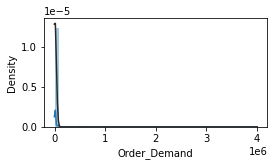

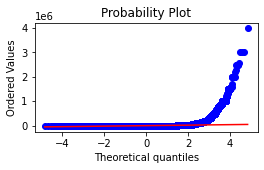

In [13]:
#Checking the ditribution of Order_Demand
from matplotlib import rcParams

rcParams['figure.figsize'] = 4,2
sb.distplot(df['Order_Demand'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [15]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [16]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


### Data Visualization for Exploratory Analysis

33


C:\Users\varya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Product_Category', ylabel='count'>

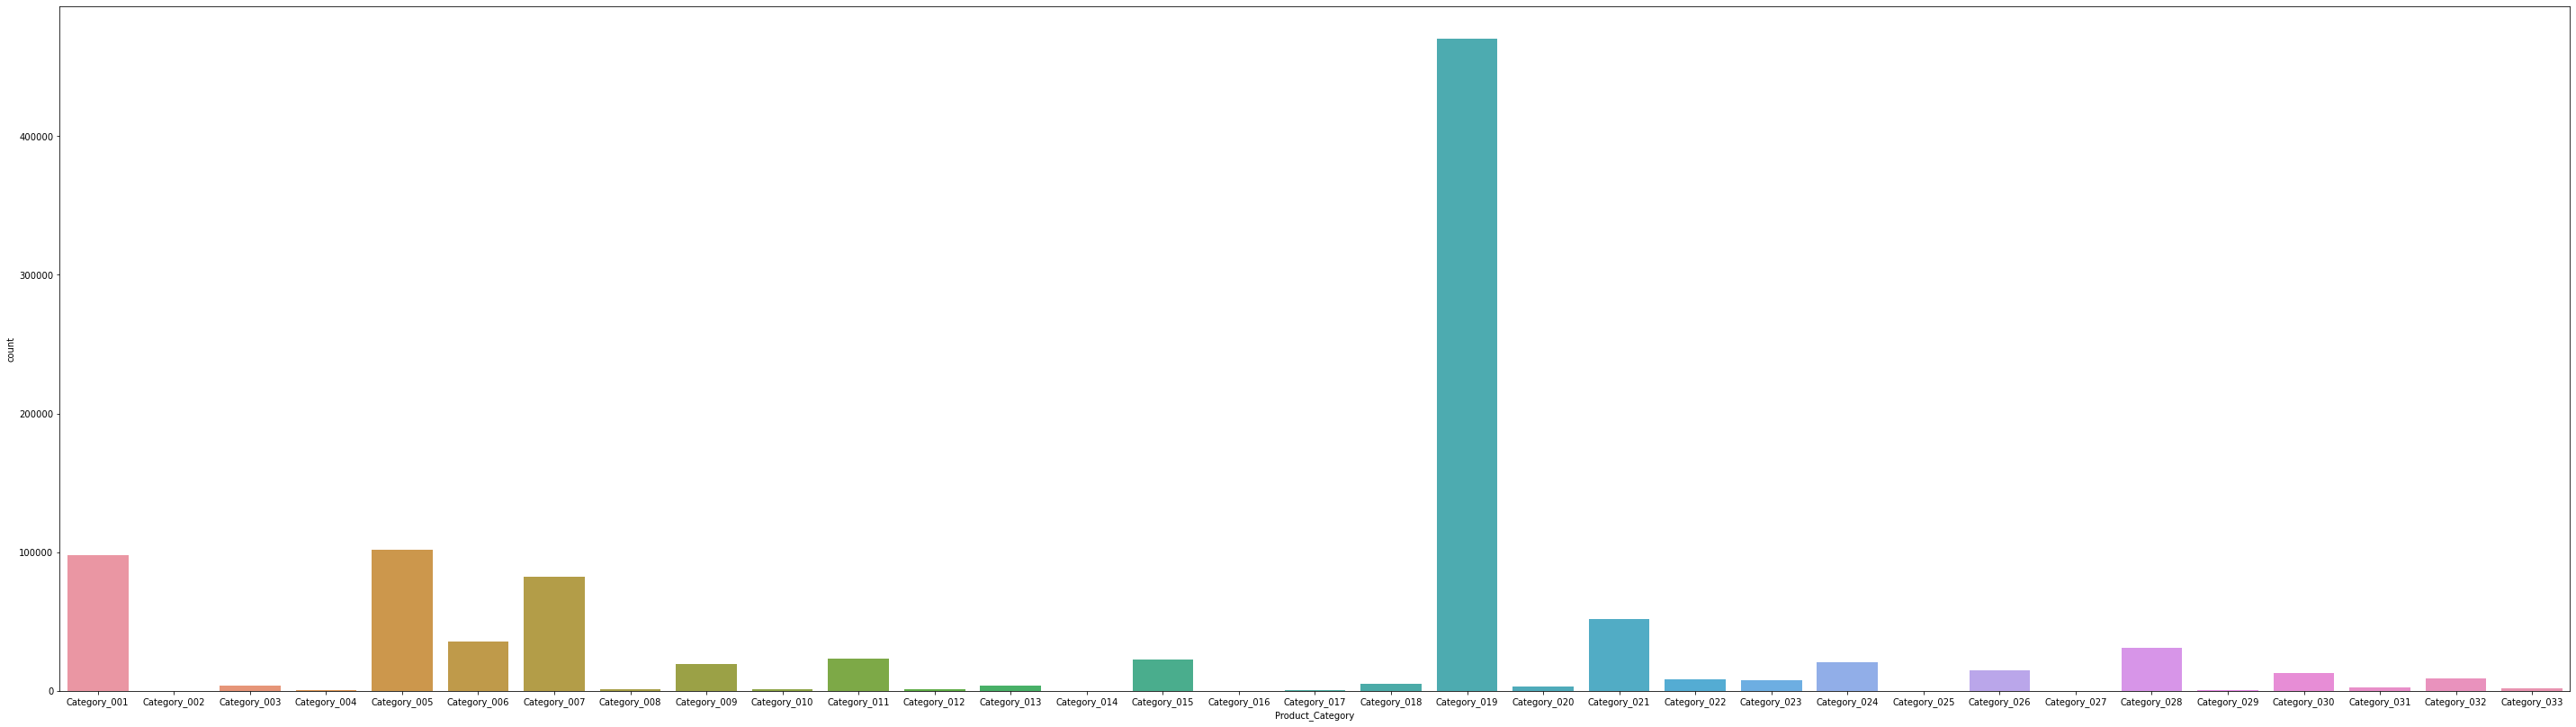

In [17]:
#Product Category.

print (len(df['Product_Category'].value_counts()))
rcParams['figure.figsize'] = 50,14
sb.countplot(df['Product_Category'].sort_values(ascending = True))

C:\Users\varya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\varya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


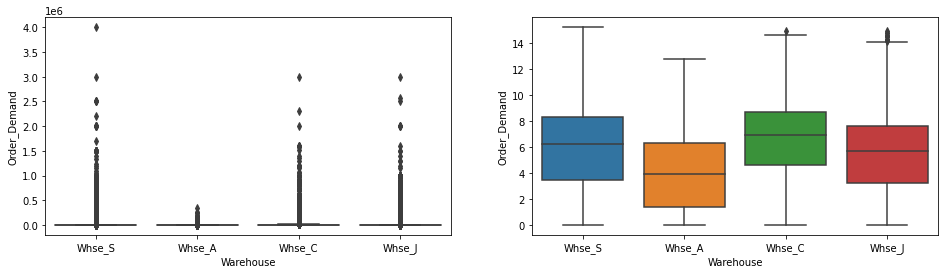

In [18]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
fig3 = sb.boxplot( df['Warehouse'],df['Order_Demand'], ax = axes[0])
fig4 = sb.boxplot( df['Warehouse'], np.log1p(df['Order_Demand']),ax = axes[1])

del fig3, fig4

In [20]:
# Getting total oders placed per day
df = df.groupby('Date')['Order_Demand'].sum().reset_index()

In [21]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [22]:
y = df['Order_Demand'].resample('MS').mean()

### Time Series Decomposition. 

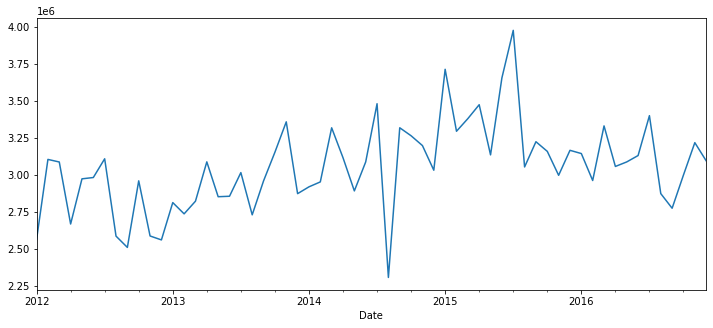

In [23]:
#Visualizing time series.

y.plot(figsize=(12,5))
plt.show()

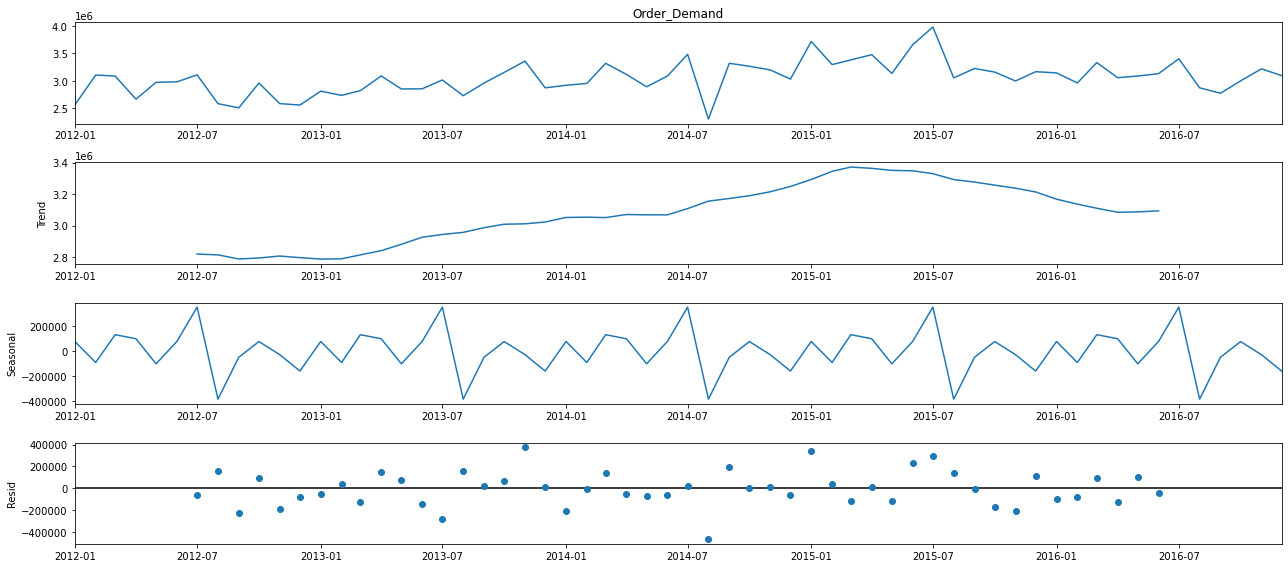

In [24]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Applying SARIMAX Function for each combination of parameters

In [25]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.9275832124356
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3134.0602952352074
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457732
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3025.077015756434
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.183803270069
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.328981334548
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3048.8520947613288
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.100572165093
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277816
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.634762975912
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2969.939154212284
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:13

In [27]:
#Fit the model with the best params.
#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018646

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


### Plotting the diagnostics.

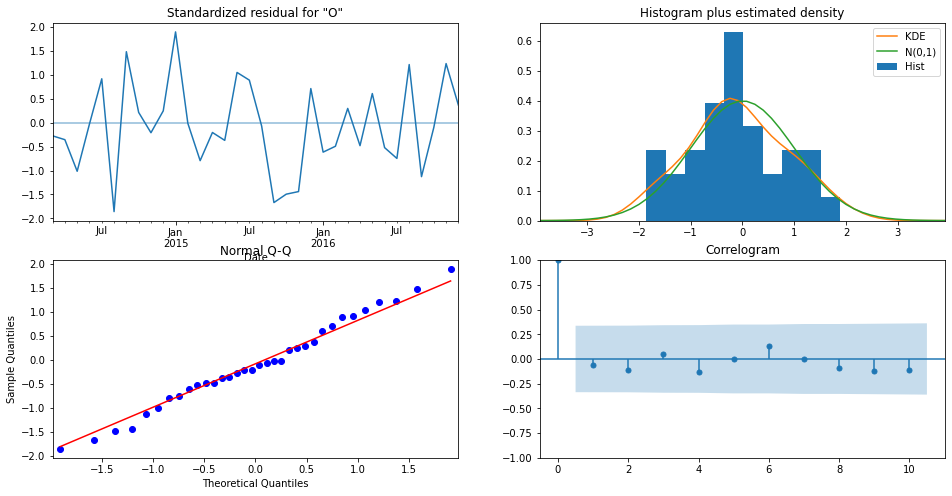

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

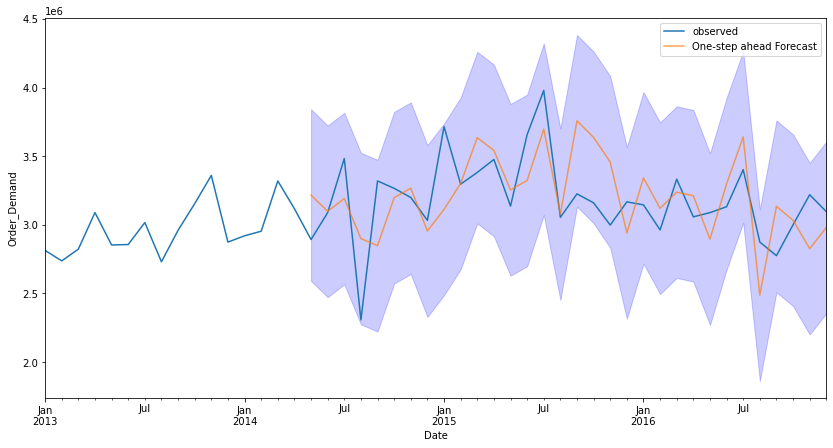

In [29]:
#Getting the prediction values
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False)
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [30]:
# Getting the mean squared error
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 55459437820.56


In [31]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 235498.28
